# Credit Risk Resampling Techniques

In [128]:
import warnings
warnings.filterwarnings('ignore')

In [129]:
# Import general libraries
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter
import matplotlib.pyplot as plt

In [130]:
# Import sklearn libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import balanced_accuracy_score

In [131]:
# Import imblearn libraries
from imblearn.metrics import classification_report_imbalanced
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import ClusterCentroids
from imblearn.combine import SMOTEENN

# Read the CSV and Perform Basic Data Cleaning

In [132]:
columns = [
    "loan_amnt", "int_rate", "installment", "home_ownership",
    "annual_inc", "verification_status", "issue_d", "loan_status",
    "pymnt_plan", "dti", "delinq_2yrs", "inq_last_6mths",
    "open_acc", "pub_rec", "revol_bal", "total_acc",
    "initial_list_status", "out_prncp", "out_prncp_inv", "total_pymnt",
    "total_pymnt_inv", "total_rec_prncp", "total_rec_int", "total_rec_late_fee",
    "recoveries", "collection_recovery_fee", "last_pymnt_amnt", "next_pymnt_d",
    "collections_12_mths_ex_med", "policy_code", "application_type", "acc_now_delinq",
    "tot_coll_amt", "tot_cur_bal", "open_acc_6m", "open_act_il",
    "open_il_12m", "open_il_24m", "mths_since_rcnt_il", "total_bal_il",
    "il_util", "open_rv_12m", "open_rv_24m", "max_bal_bc",
    "all_util", "total_rev_hi_lim", "inq_fi", "total_cu_tl",
    "inq_last_12m", "acc_open_past_24mths", "avg_cur_bal", "bc_open_to_buy",
    "bc_util", "chargeoff_within_12_mths", "delinq_amnt", "mo_sin_old_il_acct",
    "mo_sin_old_rev_tl_op", "mo_sin_rcnt_rev_tl_op", "mo_sin_rcnt_tl", "mort_acc",
    "mths_since_recent_bc", "mths_since_recent_inq", "num_accts_ever_120_pd", "num_actv_bc_tl",
    "num_actv_rev_tl", "num_bc_sats", "num_bc_tl", "num_il_tl",
    "num_op_rev_tl", "num_rev_accts", "num_rev_tl_bal_gt_0",
    "num_sats", "num_tl_120dpd_2m", "num_tl_30dpd", "num_tl_90g_dpd_24m",
    "num_tl_op_past_12m", "pct_tl_nvr_dlq", "percent_bc_gt_75", "pub_rec_bankruptcies",
    "tax_liens", "tot_hi_cred_lim", "total_bal_ex_mort", "total_bc_limit",
    "total_il_high_credit_limit", "hardship_flag", "debt_settlement_flag"
]

target = ["loan_status"]

In [133]:
print(len(columns))

86


In [134]:
# Load the original data
file_path = Path('LoanStats_2019Q1.csv')
df = pd.read_csv(file_path, skiprows=1)[:-2]
df = df.loc[:, columns].copy()

In [135]:
# Find out whether the data is balanced or not
df.shape

(115675, 86)

In [136]:
# Drop the null columns where all values are null
df = df.dropna(axis='columns', how='all')

# Drop the null rows
df = df.dropna()

# Remove the `Issued` loan status
issued_mask = df['loan_status'] != 'Issued'
df = df.loc[issued_mask]

# convert interest rate to numerical
df['int_rate'] = df['int_rate'].str.replace('%', '')
df['int_rate'] = df['int_rate'].astype('float') / 100

# Convert the target column values to low_risk and high_risk based on their values
x = {'Current': 'low_risk'}   
df = df.replace(x)

x = dict.fromkeys(['Late (31-120 days)', 'Late (16-30 days)', 'Default', 'In Grace Period'], 'high_risk')    
df = df.replace(x)

df.reset_index(inplace=True, drop=True)

df.head()

,loan_amnt,int_rate,installment,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,dti,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag
0,10500.0,0.1719,375.35,RENT,66000.0,Source Verified,Mar-2019,low_risk,n,27.24,...,85.7,100.0,0.0,0.0,65687.0,38199.0,2000.0,61987.0,N,N
1,25000.0,0.2000,929.09,MORTGAGE,105000.0,Verified,Mar-2019,low_risk,n,20.23,...,91.2,50.0,1.0,0.0,271427.0,60641.0,41200.0,49197.0,N,N
2,20000.0,0.2000,529.88,MORTGAGE,56000.0,Verified,Mar-2019,low_risk,n,24.26,...,66.7,50.0,0.0,0.0,60644.0,45684.0,7500.0,43144.0,N,N
3,10000.0,0.1640,353.55,RENT,92000.0,Verified,Mar-2019,low_risk,n,31.44,...,100.0,50.0,1.0,0.0,99506.0,68784.0,19700.0,76506.0,N,N
4,22000.0,0.1474,520.39,MORTGAGE,52000.0,Not Verified,Mar-2019,low_risk,n,18.76,...,100.0,0.0,0.0,0.0,219750.0,25919.0,27600.0,20000.0,N,N


# Split the Data into Training and Testing

In [137]:
# Find categorical value columns, columns that have an "object" datatype are not binary
columns_obj = df.select_dtypes(include='object').columns
columns_obj

Index(['home_ownership', 'verification_status', 'issue_d', 'loan_status',
       'pymnt_plan', 'initial_list_status', 'next_pymnt_d', 'application_type',
       'hardship_flag', 'debt_settlement_flag'],
      dtype='object')

In [138]:
# Let's check one of the columns out
df["home_ownership"].value_counts()

MORTGAGE    36219
RENT        24613
OWN          7346
ANY           639
Name: home_ownership, dtype: int64

In [139]:
# Let's look at all of the object columns at one time
for column in df[columns_obj]:
    print(column, "\n", df[column].value_counts())
    print("----------------------------------")

home_ownership 
 MORTGAGE    36219
RENT        24613
OWN          7346
ANY           639
Name: home_ownership, dtype: int64
----------------------------------
verification_status 
 Not Verified       32895
Source Verified    25737
Verified           10185
Name: verification_status, dtype: int64
----------------------------------
issue_d 
 Jan-2019    31041
Feb-2019    25579
Mar-2019    12197
Name: issue_d, dtype: int64
----------------------------------
loan_status 
 low_risk     68470
high_risk      347
Name: loan_status, dtype: int64
----------------------------------
pymnt_plan 
 n    68817
Name: pymnt_plan, dtype: int64
----------------------------------
initial_list_status 
 w    60292
f     8525
Name: initial_list_status, dtype: int64
----------------------------------
next_pymnt_d 
 May-2019    42449
Apr-2019    26368
Name: next_pymnt_d, dtype: int64
----------------------------------
application_type 
 Individual    59206
Joint App      9611
Name: application_type, dtype: int64

In [140]:
# Drop the columns have have only one type of value because it's useless in terms of analysis
df = df.drop(columns=["pymnt_plan", "hardship_flag", "debt_settlement_flag"])
df.shape

(68817, 83)

In [141]:
# save the df dataframe as clean_loans_df csv file
clean_loans_df = df

# saved this cleaned version to CSV for use later
clean_loans_df.to_csv("clean_loans.csv", index=False)

In [142]:
# read newly created CSV file
df = pd.read_csv('clean_loans.csv')
df.head()

,loan_amnt,int_rate,installment,home_ownership,annual_inc,verification_status,issue_d,loan_status,dti,delinq_2yrs,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,10500.0,0.1719,375.35,RENT,66000.0,Source Verified,Mar-2019,low_risk,27.24,0.0,...,0.0,3.0,85.7,100.0,0.0,0.0,65687.0,38199.0,2000.0,61987.0
1,25000.0,0.2000,929.09,MORTGAGE,105000.0,Verified,Mar-2019,low_risk,20.23,0.0,...,0.0,6.0,91.2,50.0,1.0,0.0,271427.0,60641.0,41200.0,49197.0
2,20000.0,0.2000,529.88,MORTGAGE,56000.0,Verified,Mar-2019,low_risk,24.26,0.0,...,0.0,4.0,66.7,50.0,0.0,0.0,60644.0,45684.0,7500.0,43144.0
3,10000.0,0.1640,353.55,RENT,92000.0,Verified,Mar-2019,low_risk,31.44,0.0,...,0.0,1.0,100.0,50.0,1.0,0.0,99506.0,68784.0,19700.0,76506.0
4,22000.0,0.1474,520.39,MORTGAGE,52000.0,Not Verified,Mar-2019,low_risk,18.76,0.0,...,0.0,1.0,100.0,0.0,0.0,0.0,219750.0,25919.0,27600.0,20000.0


In [143]:
# Create our features
X = df.drop(columns=["loan_status"])
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68817 entries, 0 to 68816
Data columns (total 82 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   loan_amnt                   68817 non-null  float64
 1   int_rate                    68817 non-null  float64
 2   installment                 68817 non-null  float64
 3   home_ownership              68817 non-null  object 
 4   annual_inc                  68817 non-null  float64
 5   verification_status         68817 non-null  object 
 6   issue_d                     68817 non-null  object 
 7   dti                         68817 non-null  float64
 8   delinq_2yrs                 68817 non-null  float64
 9   inq_last_6mths              68817 non-null  float64
 10  open_acc                    68817 non-null  float64
 11  pub_rec                     68817 non-null  float64
 12  revol_bal                   68817 non-null  float64
 13  total_acc                   688

In [144]:
# Create our target
y = df["loan_status"]
y.value_counts()

low_risk     68470
high_risk      347
Name: loan_status, dtype: int64

In [145]:
# Let's turn the object columns into binary columns, this will add many more columns
X_encoded = pd.get_dummies(X)
X_encoded.shape

(68817, 92)

In [146]:
X_encoded.describe()

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,...,verification_status_Verified,issue_d_Feb-2019,issue_d_Jan-2019,issue_d_Mar-2019,initial_list_status_f,initial_list_status_w,next_pymnt_d_Apr-2019,next_pymnt_d_May-2019,application_type_Individual,application_type_Joint App
count,68817.000000,68817.000000,68817.000000,6.881700e+04,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,...,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000
mean,16677.594562,0.127718,480.652863,8.821371e+04,21.778153,0.217766,0.497697,12.587340,0.126030,17604.142828,...,0.148001,0.371696,0.451066,0.177238,0.123879,0.876121,0.383161,0.616839,0.860340,0.139660
std,10277.348590,0.048130,288.062432,1.155800e+05,20.199244,0.718367,0.758122,6.022869,0.336797,21835.880400,...,0.355104,0.483261,0.497603,0.381873,0.329446,0.329446,0.486161,0.486161,0.346637,0.346637
min,1000.000000,0.060000,30.890000,4.000000e+01,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9000.000000,0.088100,265.730000,5.000000e+04,13.890000,0.000000,0.000000,8.000000,0.000000,6293.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,15000.000000,0.118000,404.560000,7.300000e+04,19.760000,0.000000,0.000000,11.000000,0.000000,12068.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000
75%,24000.000000,0.155700,648.100000,1.040000e+05,26.660000,0.000000,1.000000,16.000000,0.000000,21735.000000,...,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,40000.000000,0.308400,1676.230000,8.797500e+06,999.000000,18.000000,5.000000,72.000000,4.000000,587191.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [147]:
# Perform more pre-processing to standard scale the X_encoded data (Module 17.6.4)
# Notice that the values between columns have a very wide range, from 68,817 to 0.127718
# This may affect the model between it is sensitie to large numerical values
# We'll use StandardScaler to rescale each feature so that its mean is 0 and it's standard deviation is 1
data_scaler = StandardScaler()

# skilearn allows you to fit and transform in one step with this method
X_encoded_scaled = data_scaler.fit_transform(X_encoded)
X_encoded_scaled[:1]

array([[-0.60109272,  0.91798436, -0.36555835, -0.1921948 ,  0.27040056,
        -0.30314253, -0.65649151, -0.76165917, -0.37420432, -0.73252183,
        -0.8658573 , -0.58124513, -0.58081958, -0.50046544, -0.50029335,
        -0.3228639 , -0.89960419, -0.03227363,  0.        ,  0.        ,
        -0.17383528, -0.12011247,  0.        ,  0.        , -0.00589695,
        -0.72692228,  1.67997825,  0.2392533 ,  1.19137226,  1.35299632,
        -0.80895603, -0.13418715, -0.45717571, -0.16310175, -0.24864022,
        -0.83203994,  0.12422197, -1.04213361, -0.24758239, -0.59166015,
         0.75578041,  0.37274923, -0.59052419, -0.80915288,  1.04494582,
        -0.07820908, -0.00778953, -0.56994022, -0.7981628 , -0.64845959,
        -0.66313947, -0.8249868 , -0.14674317, -1.10824038, -0.33490355,
        -1.13862411, -1.05103022, -1.27998521, -1.40011594,  0.06599699,
        -1.11347944, -1.31043257, -1.0519437 , -0.75930693,  0.        ,
         0.        , -0.13347217,  0.41138923, -1.1

In [148]:
# Let's see what y looks like
y.shape

(68817,)

In [149]:
#Split the data using the newly created X data that was cleaned, encoded and scaled)
X_train, X_test, y_train, y_test = train_test_split(X_encoded_scaled, y, random_state=1)

In [150]:
# Checkout the values in the trained y data
y_train.value_counts()

low_risk     51366
high_risk      246
Name: loan_status, dtype: int64

In [151]:
# Percentage of high-risk data
print(246/51366)

0.004789160144842892


In [152]:
# Get a basline of the performance. Use LogisticRegression classifier to make predictions and evaluate model's performance
#Instantiate a Logistic Regression Model

#Model
baseline_model = LogisticRegression(solver='lbfgs', random_state=1)

#fit our model wiht our data (training)
baseline_model.fit(X_train, y_train)

#Predict
y_pred = baseline_model.predict(X_test)

In [153]:
# Show Predictions vs. Actuals from the baseline model
pd.DataFrame({"Predictions": y_pred, "Actual": y_test}).value_counts()

Predictions  Actual   
low_risk     low_risk     17099
             high_risk       80
high_risk    high_risk       21
             low_risk         5
dtype: int64

In [154]:
# calculate the accuracy
accuracy_score(y_test, y_pred)

0.995059575704737

In [155]:
#Create confusion matrix
matrix = confusion_matrix(y_test, y_pred)
print(matrix)

[[   21    80]
 [    5 17099]]


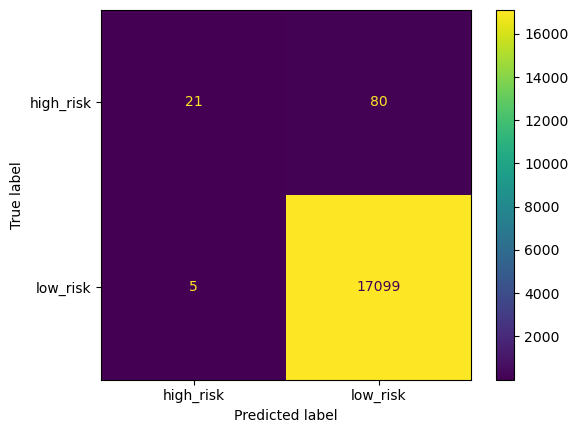

In [156]:
# Display a graphic of the Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=baseline_model.classes_)
#plt.savefig("./Images/basline_confusion_matrix.png")
disp.plot()

In [158]:
report = classification_report(y_test, y_pred)
print('Baseline Classification Report')
print(report)

Baseline Classification Report
              precision    recall  f1-score   support

   high_risk       0.81      0.21      0.33       101
    low_risk       1.00      1.00      1.00     17104

    accuracy                           1.00     17205
   macro avg       0.90      0.60      0.66     17205
weighted avg       0.99      1.00      0.99     17205



# Oversampling

In this section, you will compare two oversampling algorithms to determine which algorithm results in the best performance. You will oversample the data using the naive random oversampling algorithm and the SMOTE algorithm. For each algorithm, be sure to complete the folliowing steps:

1. View the count of the target classes using `Counter` from the collections library. 
3. Use the resampled data to train a logistic regression model.
3. Calculate the balanced accuracy score from sklearn.metrics.
4. Print the confusion matrix from sklearn.metrics.
5. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.

Note: Use a random state of 1 for each sampling algorithm to ensure consistency between tests

In [159]:
# Let's see what the Imbalanced Classification Report looks like
report = classification_report_imbalanced(y_test, y_pred)
print('Baseline Imbalanced Classification Report')
print(report)

Baseline Imbalanced Classification Report
                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.81      0.21      1.00      0.33      0.46      0.19       101
   low_risk       1.00      1.00      0.21      1.00      0.46      0.22     17104

avg / total       0.99      1.00      0.21      0.99      0.46      0.22     17205



### Naive Random Oversampling

In [160]:
# Resample the training data with the RandomOversampler
ros = RandomOverSampler(random_state=1)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
Counter(y_resampled)

Counter({'low_risk': 51366, 'high_risk': 51366})

In [161]:
# Train the Logistic Regression model using the resampled data

# model
ros_model = LogisticRegression(solver='lbfgs', random_state=1)

# fit
ros_model.fit(X_resampled, y_resampled)

#predict
y_pred = ros_model.predict(X_test)

In [162]:
# Calculated the balanced accuracy score
# predict
balanced_accuracy_score(y_test, y_pred)

0.8325468421491353

In [163]:
# Display the confusion matrix
matrix = confusion_matrix(y_test, y_pred, labels=ros_model.classes_)
print(matrix)

[[   83    18]
 [ 2680 14424]]


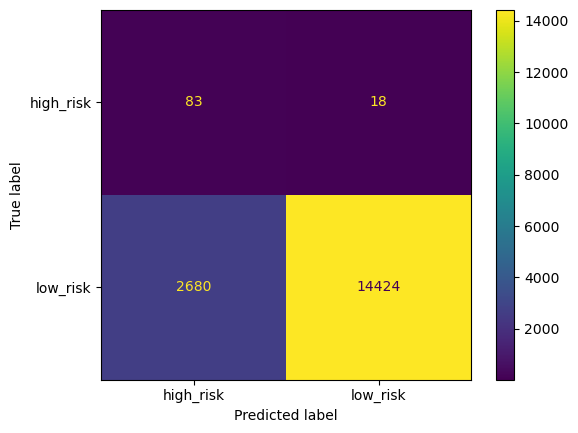

In [164]:
#Display graph of confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=ros_model.classes_)
#plt.savefig("./Images/RandomOverSampler_confusion_matrix.png")
disp.plot()

In [166]:
# Print the imbalanced classification report
report = classification_report_imbalanced(y_test, y_pred)
print('Random Oversampling Imbalance Classification Rpt')
print(report)

Random Oversampling Imbalance Classification Rpt
                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.03      0.82      0.84      0.06      0.83      0.69       101
   low_risk       1.00      0.84      0.82      0.91      0.83      0.69     17104

avg / total       0.99      0.84      0.82      0.91      0.83      0.69     17205



### SMOTE Oversampling

In [167]:
# Resample the training data with SMOTE
X_resampled, y_resampled = SMOTE(random_state=1, sampling_strategy='auto').fit_resample(X_train, y_train)
Counter(y_resampled)

Counter({'low_risk': 51366, 'high_risk': 51366})

In [168]:
# Train the Logistic Regression model using the resampled data
# Model
smote_model = LogisticRegression(solver='lbfgs', random_state=1)

# Fit
smote_model.fit(X_resampled, y_resampled)

# Predict
y_pred = smote_model.predict(X_test)

In [169]:
# Calculated the balanced accuracy score
balanced_accuracy_score(y_test, y_pred)

0.8440938486973113

In [170]:
# Display the confusion matrix
matrix = confusion_matrix(y_test, y_pred, labels=smote_model.classes_)
print(matrix)

[[   83    18]
 [ 2285 14819]]


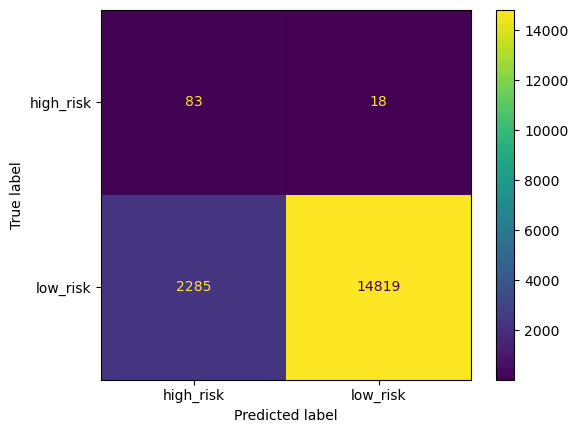

In [171]:
disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=smote_model.classes_)
#plt.savefig("./Images/SMOTE_confusion_matrix.png")
disp.plot()

In [180]:
# Print the imbalanced classification report
print('SMOTE Oversampling Imbalance Classification Report')
print(classification_report_imbalanced(y_test, y_pred))

SMOTE Oversampling Imbalance Classification Report
                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.02      0.88      0.76      0.04      0.82      0.68       101
   low_risk       1.00      0.76      0.88      0.86      0.82      0.66     17104

avg / total       0.99      0.76      0.88      0.86      0.82      0.66     17205



# Undersampling

In this section, you will test an undersampling algorithms to determine which algorithm results in the best performance compared to the oversampling algorithms above. You will undersample the data using the Cluster Centroids algorithm and complete the folliowing steps:

1. View the count of the target classes using `Counter` from the collections library. 
3. Use the resampled data to train a logistic regression model.
3. Calculate the balanced accuracy score from sklearn.metrics.
4. Print the confusion matrix from sklearn.metrics.
5. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.

Note: Use a random state of 1 for each sampling algorithm to ensure consistency between tests

In [173]:
# Resample the data using the ClusterCentroids resampler
# Warning: This is a large dataset, and this step may take some time to complete
cc = ClusterCentroids(random_state=1)
X_resampled, y_resampled = cc.fit_resample(X_train, y_train)

In [174]:
# Train the Logistic Regression model using the resampled data
# Model
cc_model = LogisticRegression(solver='lbfgs', random_state=1)

#Fit
cc_model.fit(X_resampled, y_resampled)

#Predict
y_pred = cc_model.predict(X_test)

In [175]:
# Calculated the balanced accuracy score
balanced_accuracy_score(y_test, y_pred)

0.8203882595930314

In [176]:
# Display the confusion matrix
matrix = confusion_matrix(y_test, y_pred, labels=cc_model.classes_)
print(matrix)

[[   89    12]
 [ 4112 12992]]


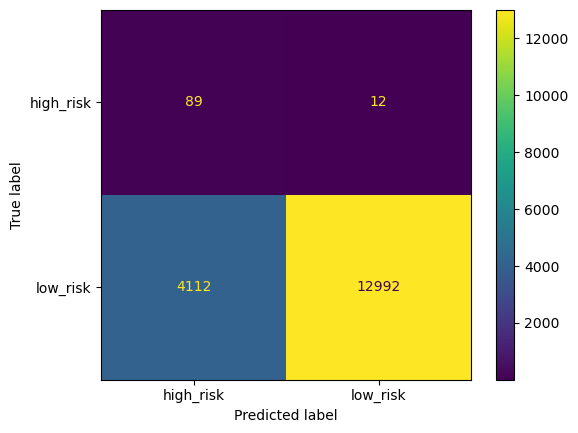

In [177]:
disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=cc_model.classes_)
#plt.savefig("./Images/ClusterCentroids_under_confusion_matrix.png")
disp.plot()

In [179]:
# Print the imbalanced classification report
print('Cluster Centroids Undersampling Imbalance Classification Report')
print(classification_report_imbalanced(y_test, y_pred))

Cluster Centroids Undersampling Imbalance Classification Report
                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.02      0.88      0.76      0.04      0.82      0.68       101
   low_risk       1.00      0.76      0.88      0.86      0.82      0.66     17104

avg / total       0.99      0.76      0.88      0.86      0.82      0.66     17205



# Combination (Over and Under) Sampling

In this section, you will test a combination over- and under-sampling algorithm to determine if the algorithm results in the best performance compared to the other sampling algorithms above. You will resample the data using the SMOTEENN algorithm and complete the folliowing steps:

1. View the count of the target classes using `Counter` from the collections library. 
3. Use the resampled data to train a logistic regression model.
3. Calculate the balanced accuracy score from sklearn.metrics.
4. Print the confusion matrix from sklearn.metrics.
5. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.

Note: Use a random state of 1 for each sampling algorithm to ensure consistency between tests

In [181]:
# Resample the training data with SMOTEENN
# Warning: This is a large dataset, and this step may take some time to complete
smote_enn = SMOTEENN(random_state=0)
#X_resampled, y_resampled = SMOTE(random_state=1, sampling_strategy='auto').fit_resample(X_train, y_train)

X_resampled, y_resampled = smote_enn.fit_resample(X_train, y_train)

Counter(y_resampled)

Counter({'high_risk': 51366, 'low_risk': 47640})

In [182]:
# Train the Logistic Regression model using the resampled data
smoteenn_model = LogisticRegression(solver='lbfgs', random_state=1)
smoteenn_model.fit(X_resampled, y_resampled)
y_pred = smoteenn_model.predict(X_test)

In [183]:
# Calculated the balanced accuracy score
balanced_accuracy_score(y_test, y_pred)

0.844016280135965

In [184]:
matrix = confusion_matrix(y_test, y_pred, labels=smoteenn_model.classes_)
print(matrix)

[[   84    17]
 [ 2457 14647]]


<Figure size 640x480 with 0 Axes>

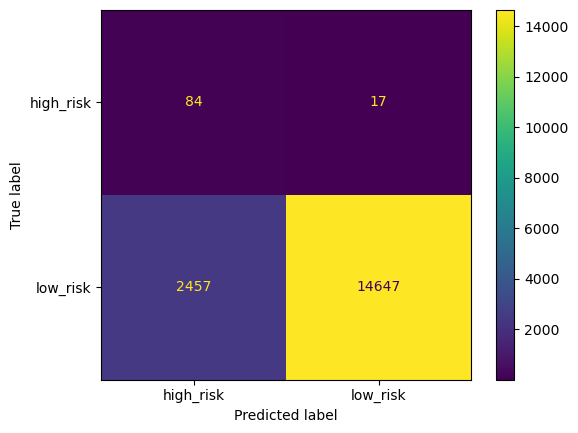

In [185]:
# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=smoteenn_model.classes_)
plt.savefig("./Images/SMOTEENN_confusion_matrix.png")
disp.plot()

In [187]:
# Print the imbalanced classification report
print('SMOTEENN Imbalance Classification Report')
print(classification_report_imbalanced(y_test, y_pred))

SMOTEENN Imbalance Classification Report
                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.03      0.83      0.86      0.06      0.84      0.71       101
   low_risk       1.00      0.86      0.83      0.92      0.84      0.71     17104

avg / total       0.99      0.86      0.83      0.92      0.84      0.71     17205

